C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['Gulim'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


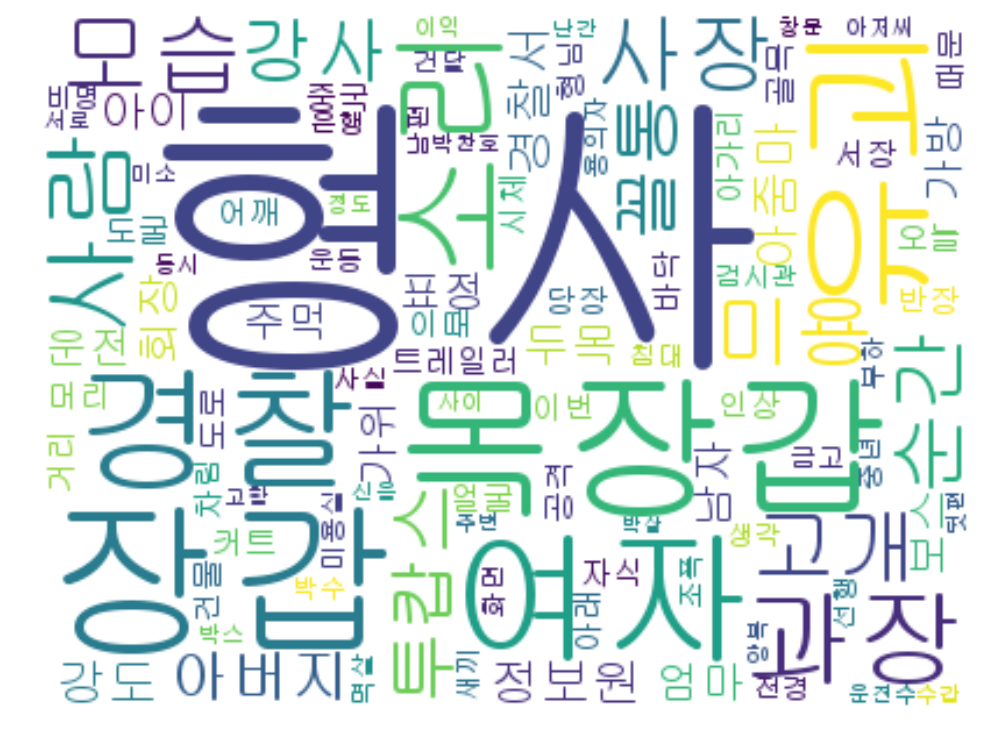

C:\Users\USER\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


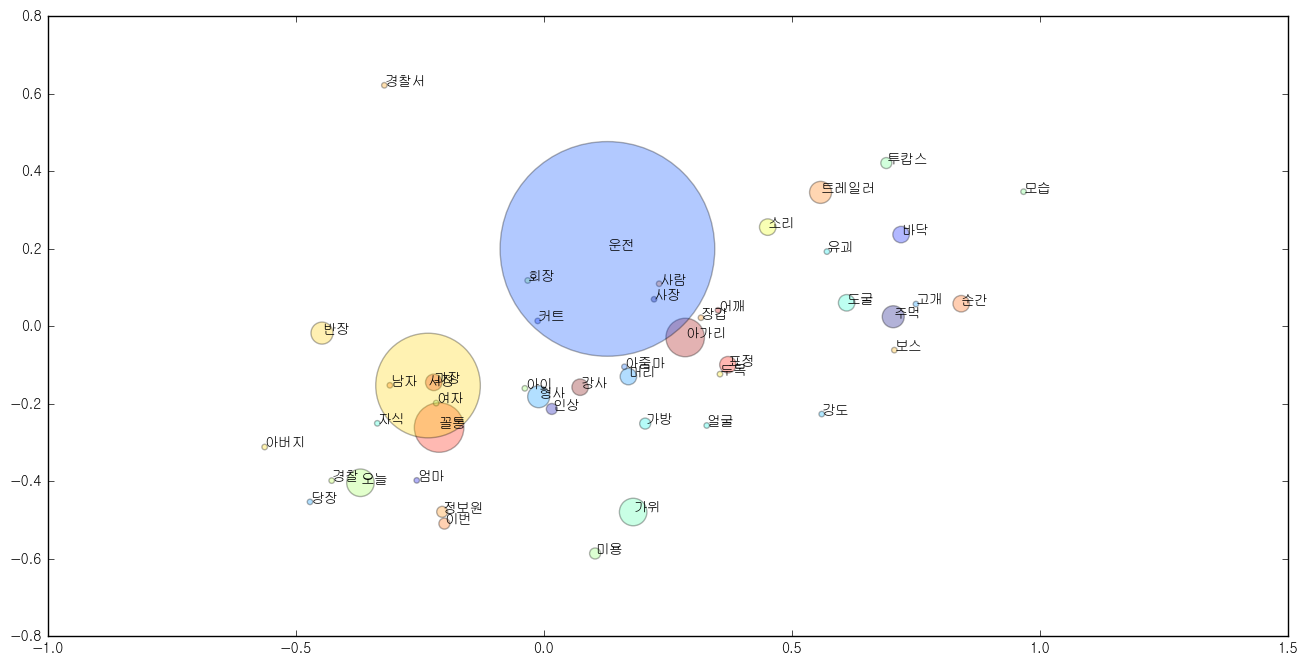

In [1]:
from konlpy.tag import Komoran
tagger = Komoran()  # 형태소 분석기
from urllib.parse import quote_plus
from bs4 import BeautifulSoup
import requests
import lxml.html
import codecs

#투캅스 시나리오 읽어오기
#이 시나리오 데이터는 제공되어질수 없으며 배포가 불가능하오니 
#http://www.korean.go.kr(국립국어원)에서 회원가입을 하시고 다운을 받아주세요. 
articles = []
fp = codecs.open("투캅스(배포불가).txt", "r", encoding="utf-8")
soup = BeautifulSoup(fp, "html.parser")
body = soup.select_one("body")
text = body.getText()
articles = text.split("\n")
len(articles)
fp.close()

from sklearn.feature_extraction.text import TfidfVectorizer

#명사만 추출
def get_noun(text):
    nouns = tagger.nouns(text)
    return [n for n in nouns if len(n) > 1]  # 2글자 이상인 명사만 추출

#TF-IDF 행렬구하기
cv = TfidfVectorizer(tokenizer=get_noun, max_features=100)
tdm = cv.fit_transform(articles)

#print(tdm.toarray())
#print(tdm) 

import numpy
import operator
words = cv.get_feature_names()
count_mat = tdm.sum(axis=0)
count = numpy.squeeze(numpy.asarray(count_mat))
word_count = list(zip(words, count))
word_count = sorted(word_count, key=operator.itemgetter(1), reverse=True)
word_count

hot_key = list(dict(word_count[:50]).keys())
hot_key

#word cloud
%matplotlib inline
from matplotlib import pyplot
from wordcloud import WordCloud
wc = WordCloud(font_path='C:\\Windows\\Fonts\\NGULIM.ttf', background_color='white', width=400, height=300)
cloud = wc.fit_words(dict(word_count))
pyplot.figure(figsize=(12, 9))
pyplot.imshow(cloud)
pyplot.axis("off")
pyplot.show()

#형태소 분석기 라이브러리 로딩
import codecs
from konlpy.tag import Twitter
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

# 텍스트를 처리하기
twitter = Twitter()
results = []
lines = articles
words_all = []

for line in lines:
    # 형태소 분석하기
    malist = twitter.pos(line, norm=True, stem=True)
    r = []
    for word in malist:
        # 명사/동사/부사만 걸러내기 
        if word[1] in ['Noun','Verb','Adjective']:
            r.append(word[0])
            words_all.append(word[0])
    rl = (" ".join(r)).strip()
    results.append(rl)
    #print(rl)
    
# 파일로 저장하기
from gensim.models import word2vec
yang_file = 'yang.model'
with open(yang_file, 'w', encoding='utf-8') as fp2:
    fp2.write("\n".join(results))
    
fp2.close() 

# Word2Vec 모델
data = word2vec.LineSentence(yang_file)
model = word2vec.Word2Vec(data,size=200, window=10, hs=1, min_count=2, sg=1)
model.save("yang_w2v.model")

################ 테스트 ##########################################

model.most_similar(positive=["경찰"])    #경찰과 가장 가까운 단어는?
model.most_similar(positive=["여자"])    #여자와 가장 가까운 단어는?
model["장갑"]                            #장갑의 데이터 임베딩
model["유괴"]                            #유괴의 데이터 임베딩
model.most_similar(positive=["경찰","유괴"] , negative=["여자"])    #경찰 + 유괴 - 여자

#차원축소를 위한 라이브러리
from IPython.display import Image
from sklearn.decomposition import PCA

#차원을 줄여주기(그래프를 그려주기 위함) 
words = list(model.wv.vocab)
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

#word의 군집화 
result2 = StandardScaler().fit_transform(result)
db = DBSCAN(eps=0.3, min_samples=10).fit(result2)
labels = db.labels_

import collections
import math
import numpy as np 

myCounter = collections.Counter(words_all)
#print('myCounter:', myCounter)

radiuds = np.array([i for i in list(myCounter.values())])
area = np.pi * (radiuds)**2  * 5
table_words = list(myCounter.keys()) 
table_counts = list(list(myCounter.values()))

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.font_manager import FontProperties
import matplotlib.font_manager as fm 

#top50의 단어를 선별하여 word2vec을 계산하고 좌표로 찍어준다. 
font_location = "C:\\Windows\\Fonts\\NGULIM.TTF"
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

valid_words = [hot_key[i] for i in range(0,50) if hot_key[i] in words]
valid_labels = [words.index(hot_key[i]) for i in range(0,50) if hot_key[i] in words]
valid_index = [words.index(str_temp) for str_temp in valid_words]   
valid_area = area[[table_words.index(str_temp) for str_temp in valid_words]]   
zip_index = zip(valid_index,valid_words)

plt.figure(figsize=(16, 8))
plt.scatter(result[valid_index, 0], result[valid_index, 1] , c = valid_labels , s = area , alpha=0.3)
for i, word in zip_index:
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
    
plt.show()




In [2]:
model.most_similar(positive=["경찰"])

[('건', 0.9847097396850586),
 ('그만두다', 0.9818676710128784),
 ('무슨', 0.980807900428772),
 ('애', 0.9807289838790894),
 ('성공', 0.9807137250900269),
 ('인간', 0.9805092215538025),
 ('만들다', 0.9764254093170166),
 ('몰르다', 0.9750664234161377),
 ('나', 0.9746274352073669),
 ('날', 0.9726292490959167)]

In [3]:
model.most_similar(positive=["여자"])

[('시작', 0.9503136277198792),
 ('개', 0.950105607509613),
 ('꼬', 0.9495433568954468),
 ('모르다', 0.9493494629859924),
 ('드리다', 0.9472899436950684),
 ('강간', 0.9451598525047302),
 ('자네', 0.9450918436050415),
 ('않다', 0.9443750381469727),
 ('잊다', 0.9439809322357178),
 ('자루', 0.9437516927719116)]

In [4]:
model["장갑"]

array([-0.03555622, -0.0249389 ,  0.22303835,  0.02328682,  0.10752558,
       -0.06749073,  0.11020991,  0.0712173 , -0.10453828,  0.05412339,
        0.0754525 ,  0.22819053, -0.02835625, -0.22974283,  0.15265   ,
        0.3019426 ,  0.14129959,  0.12093915,  0.16627117,  0.03417147,
       -0.03756028,  0.10068487, -0.14105287,  0.01287062, -0.15911596,
       -0.04912054, -0.09539045, -0.19787447, -0.0670848 ,  0.05391765,
        0.07883024, -0.15372166,  0.32288665, -0.19861141,  0.31363043,
       -0.08314431,  0.05564725, -0.09528125, -0.22722031,  0.03147192,
        0.09931558,  0.14855264, -0.0122389 , -0.37063578, -0.14195693,
        0.41099393,  0.01919871,  0.21004406, -0.07866874, -0.08125397,
       -0.08428956,  0.1585957 , -0.08822464, -0.01896043,  0.02059391,
        0.01076963, -0.19675119, -0.01878767, -0.10924095, -0.04732709,
        0.13413858,  0.2904441 ,  0.16141263,  0.0620458 ,  0.05522372,
        0.07924075, -0.01584299, -0.01376818,  0.08150522, -0.06

In [5]:
model["유괴"]

array([ 0.03580527,  0.01521021,  0.05026457,  0.00273443,  0.04154437,
       -0.09052167,  0.08582908,  0.08502345,  0.09097986, -0.01741421,
        0.02313065,  0.05611897, -0.05279098, -0.13183549,  0.04499672,
        0.09059288,  0.13531195,  0.08847775,  0.12666297,  0.10406727,
        0.01702013,  0.16796973, -0.01443233,  0.01573481, -0.01985671,
       -0.10937791, -0.06963952,  0.00882201, -0.02578413,  0.07972024,
       -0.00148115, -0.22076564,  0.02607616,  0.05384791,  0.16998123,
        0.08712073, -0.04576043, -0.01522005, -0.04581743, -0.08983857,
        0.05248914,  0.04258676,  0.02640502, -0.255009  ,  0.00975768,
        0.14512876,  0.06288876,  0.06552812,  0.10574735,  0.06851427,
       -0.16851746,  0.04608048, -0.06525592, -0.10534813, -0.13126846,
        0.0470497 , -0.20766895,  0.0546752 , -0.0604367 , -0.09136613,
        0.12571324,  0.11298153, -0.06194417,  0.04190574,  0.03300916,
       -0.08051179,  0.00047962,  0.05137327, -0.02198694, -0.12

In [6]:
model.most_similar(positive=["경찰","유괴"] , negative=["여자"])

[('마', 0.8763430118560791),
 ('또', 0.8609185218811035),
 ('아이', 0.840008020401001),
 ('빼앗다', 0.8352148532867432),
 ('날다', 0.8345879316329956),
 ('리', 0.833272397518158),
 ('흥분', 0.8324246406555176),
 ('새끼', 0.8321524858474731),
 ('부킹', 0.8311046361923218),
 ('뒷덜미', 0.8309106826782227)]

In [7]:
lines

['',
 '씬 1 달리는 버스 안',
 '타이틀이 끝나고 F.I 되면―',
 '경쾌하게 달려와 서는 시내버스.',
 '치익, 소리와 함께 문이 열리자 기다리고 있던 사람들이 올라탄다.',
 '버스카드 혹은 현금함 앞으로 오가는 손들을 바라보던',
 '운전수:(그냥 지나치는 사람을 발견하곤)아저씨, 차비 내셔야죠?',
 '하며 운전수가 노려보면, 가방을 메고 지나쳐 가다가 뒤돌아보는 꼴통, 특유의 인상을 긁으며 들고있던 볼펜을 운전수에게 내민다. 시선을 피하며 차를 출발시키는 운전수, 꼴통, 버스 가운데쯤에 서서 가방을 털썩 내려놓더니 볼펜 한자루를 치켜들며',
 '꼴통:(뒤뚱뒤뚱 인사를 하고)차 안에 계신 신사, 숙녀 여러분 안녕하십니까. 저는 홧김에 폭력, 겁도 없이 유괴, 불타는 가슴으로 강간 등 도합, 전과 십이범으로 얼마전에 출소한 대책없는 어린양입니다.(시선을 피한 승객들에게 볼펜을 한자루씩 올려놓으며)아픈 과거는 잊고 꼬딱지만한 포장마차라고 장만할까하니, 액땜한다 생각하시고 가볍게 지갑을 열어주시기 바랍니다. 여러분의 가정에 불행이 없기를 간절히 소망하며(볼펜을 들어보이며)이 볼펜을 단돈 삼천원에 드리겠습니다. 감사합니다.',
 '인사를 하고는 돈을 거둬들이려 돌아다니는 꼴통, 험악한 인상을 써보이자 순순히 돈을 주는 아가씨. 깐깐해 보이는 남자가 볼펜을 돌려주자',
 '꼴통:난 열받으면 입보다 주먹이 먼저 나가는 놈이지요.',
 '하며 사내 앞으로 주먹을 내밀자, 얼른 지갑에서 돈을 꺼내 주는 사내. 이번엔 꾸벅 꾸벅 졸고 있는 고등학생에게 다가가',
 '꼴통:(툭툭)야, 야!',
 '하지만 깨지 않자 뒷통수를 퍽퍽치며',
 '꼴통:임마, 자는 척 하지마.',
 '학생:왜 그러세요?',
 '꼴통:삼천원 내.',
 '학생:왜요?',
 '꼴통:내라면 내, 빨리 안내!',
 '고등학생이 돈을 꺼내자 다음으로 넘어간다. 꼴통, 아이를 안고 창밖을 보는 척 하는 아줌마를 보곤 아이의 머리를 쓰다듬으며',
 '꼴통:아이구 귀여워라.',
 '아줌마, 돌아보자

In [8]:
word_count

[('형사', 637.495123488858),
 ('장갑', 67.4818976523597),
 ('목장갑', 59.10778548169973),
 ('여자', 49.76553961958852),
 ('유괴', 48.32788464603059),
 ('경찰', 47.85793138201888),
 ('소리', 39.060901292946596),
 ('과장', 38.859694922850856),
 ('사람', 34.64332659053126),
 ('모습', 29.444213936131657),
 ('사장', 28.622265568714038),
 ('고개', 24.25366844773219),
 ('순간', 24.155018603050273),
 ('미용', 23.935365334337508),
 ('강사', 22.771670693344337),
 ('투캅스', 22.358192968549854),
 ('꼴통', 22.338680883991263),
 ('아버지', 20.539283410600166),
 ('정보원', 19.990421601732976),
 ('경찰서', 19.444029195134917),
 ('아줌마', 18.747819547979066),
 ('강도', 18.65901733754711),
 ('두목', 17.744495959796023),
 ('회장', 16.73654945507797),
 ('아이', 16.709449492438914),
 ('엄마', 15.108555449241486),
 ('표정', 14.76722509216091),
 ('가위', 14.724897739696242),
 ('보스', 14.254840870658896),
 ('가방', 13.696820232732916),
 ('남자', 13.472942374215279),
 ('주먹', 13.28435260951563),
 ('운전', 13.136437229929726),
 ('트레일러', 13.059322674618558),
 ('서장', 12.870423624